# The heterogenous causal effect of Bilateral Investment  Agreements on Foreign Direct Investment (FDI): A machine lerning approach

# Part 3 of 4

Recent advances in the estimation of heterogenous causal effects build on supervised machine learning methods that have  been traditionally used for predictive tasks. Assuming unconfoundedness, we estimate and compare 4 different models. Each model in implemeted in a dedicated notebook.  


Project overview:

**Models 1 and 2 : Double Machine Learning causal effect estimation**

Under the assumption of unconfoundedness, it is possible to estimate unbiased causal effects of a policy intervention (in our case a Bilateral Investment Agreement) by taking in consideration selection into treatment. Double Machine Learning models consists of 3 main steps:

1. Prediction of the presence of a BIT between two countries using a set of socio economic characterisitcs
2. Prediction of the FDI flows between the two countries using a set of sociao economic characteristics
3. Estimation of the causal effect of the BIT on FDI flows, making use of the difference between the predicted values of the first two steps and their respective observed values.

For **Model 1** and **Model 2**, the first two steps are identical, and estimated using a RandomForestClassifier and a RandomForestRegression model, respectively. The two models differ in the third step:


* *Model 1: Parametric estimation:* the third step is estimated using a traditional linear regression model.



* *Model 2: Non-parametric estimation:* the third step is estimated using a Causal Random Forest




**Models 3 and 4 : Doubly robust  causal effect estimation**

Doubly robust methods different from the estimation techniques used in model 1 and 2  in that the prediction of the outcome of interest also uses the treatment variable. The technique used for step 3 of models 3 and 4 therefore match those of models 1 and 2, but they use different predicted values for step 2, and therefore will yield different results.


All estimations are made using the **econoML** library:
* https://econml.azurewebsites.net/reference.html
* https://econml.azurewebsites.net/spec/estimation.html



In [1]:
import econml
import os
import numpy as np
import pandas as pd

## Ignore warnings
import warnings
warnings.filterwarnings("ignore")

# Main imports
from econml.dml import LinearDML, CausalForestDML
from econml.dr import LinearDRLearner, ForestDRLearner

# Helper imports

from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier
from sklearn.preprocessing import PolynomialFeatures
import matplotlib.pyplot as plt
import matplotlib

from sklearn.model_selection import train_test_split

%matplotlib inline

In [2]:
os.chdir('C:/Users/desil/Documents/GitHub/EconML')

## Import data

In [3]:
# read in data
# read in data
d = pd.read_csv('https://raw.githubusercontent.com/desval/CAS_final_project/main/data/CAS_fdi_panel_complete.csv', sep=',')
d.shape

In [4]:
d.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18953 entries, 0 to 18952
Data columns (total 48 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   ID_dir             18953 non-null  object 
 1   year               18953 non-null  int64  
 2   stock              18953 non-null  float64
 3   th_o               18953 non-null  int64  
 4   th_d               18953 non-null  int64  
 5   bit                18953 non-null  int64  
 6   desta_pta          18953 non-null  int64  
 7   desta_depth        18953 non-null  int64  
 8   desta_full_fta     18953 non-null  int64  
 9   desta_iprs         18953 non-null  int64  
 10  desta_procurement  18953 non-null  int64  
 11  desta_standards    18953 non-null  int64  
 12  desta_services     18953 non-null  int64  
 13  desta_investments  18953 non-null  int64  
 14  desta_competition  18953 non-null  int64  
 15  contig             18953 non-null  int64  
 16  dist               189

## Prepare data 

Ideally should use all of the years, but when computing the fixed effects (FE), the dimension increases by a lot and we run into RAM issues. There are approximately 25000 unique country pairs, and therefore the matrix of FE has dimenstion 268000 x 25000. For the time being, reduce the years coverage of the data. 

In [5]:
# count observations by year
d.groupby(['year']).size()

year
2017    18953
dtype: int64

In [6]:
# subset data according to year
# for the moment we use the data in cross-section
#d = d[ (d["year"] == 2002) | (d["year"] == 2012) | (d["year"] == 2018)  ]

d = d[ d["year"] == 2017  ]

In [7]:
d = d[ d["stock"] != 0  ]

In [8]:
# split into train and test
d_train, d_test = train_test_split( d,
                               test_size=0.1,
                               random_state=42,
                               stratify=d['year'])

The outcome of interest is the stock of FDI from source in the destination country. When studying the intensive margin we only consider FDI values that are positive and take the log. Alternatively, use a log trans that preserves the zeros.

(array([  1.,   1.,   4.,  11.,  58., 121., 212., 227., 120.,  25.]),
 array([-17.30230139, -14.28746865, -11.27263592,  -8.25780318,
         -5.24297045,  -2.22813771,   0.78669502,   3.80152776,
          6.81636049,   9.83119323,  12.84602596]),
 <a list of 10 Patch objects>)

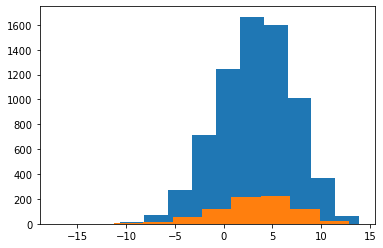

In [9]:
y_train = np.log(d_train['stock'].values) 
plt.hist(y_train)

y_test = np.log(d_test['stock'].values) 
plt.hist(y_test)



We can study different types of treatment variables:

* Binary indicators for the presence of a Bilateral Investment Agreement and a Preferential Trade Agreement
* A numeric variable for the depth of a Preferential Trade Agreement
* A set of binary variables for the different component of Preferential Trade Agreements

In [10]:
# A binary treatment for the presence of a bit
t_var = ["bit"]

t_train = d_train[t_var].values.reshape(-1,1) 
t_test = d_test[t_var].values.reshape(-1,1) 

print(t_train.shape)
print(t_test.shape)

(7012, 1)
(780, 1)


Select the variables that we want to use in the estimation of the heterogeneous effects

In [11]:
# variable for the heterogeneous effects
hetero_vars = ["gdpcap_o", "gdpcap_d"]

X_train = d_train[hetero_vars].values
X_test = d_test[hetero_vars].values


Control variables are socio-economic factors associated with both the probability of receiving the different treatment, and the outcome variables. In addition, we also have to compute the fixed effects, in order to take in accout the panel nature of the data.

In [12]:
# matrix with controls
policy_vars = [ #"desta_pta",
                "desta_full_fta",
                "desta_iprs",
                "desta_procurement",
                "desta_standards",
                "desta_services",
                "desta_investments",
                "desta_competition"]



control_drops = hetero_vars + policy_vars + t_var + ['ID_dir'] + ['stock']

W_train = d_train.drop(control_drops, axis=1).values
W_test = d_test.drop(control_drops, axis=1).values

# we also save a vector of names of the featues
W_names = np.asarray(d_train.drop(control_drops, axis=1).columns)
print(W_names.size)
W_names = np.concatenate( (np.asarray(hetero_vars), W_names), axis=None)
W_names

W_names_out = np.concatenate( ('t', W_names), axis=None)
W_names_out
print(W_names_out.size)

36
39


In [13]:
type(policy_vars)

list

In [14]:
# Create Fixed effects
# from sklearn.preprocessing import OneHotEncoder

# FE = OneHotEncoder(sparse=False).fit_transform(d['ID_dir'].values.reshape(-1, 1))

# we drop one in order to avoid multicollinearity
# W = np.append(W, FE[:, 1:], axis=1)

In [15]:
print(type(y_train))
print(type(t_train))
print(type(X_train))
print(type(W_train))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [16]:
print(y_train.shape)
print(t_train.shape)
print(X_train.shape)
print(W_train.shape)

(7012,)
(7012, 1)
(7012, 2)
(7012, 36)


Finally, we also need to prepare the vectors for analyzing the heterogenous effects

In [17]:
# gdpcap_o
x_0 = np.array(np.linspace(np.min(X_train[:,0 ]),
                           np.max(X_train[:,0 ]),
                           15)).reshape(-1,1)

In [18]:
# gdpcap_d
x_1 = np.array(np.linspace(np.min(X_train[:,1 ]),
                           np.max(X_train[:,1 ]),
                           15)).reshape(-1,1)

In [19]:
# now need to get all the combinations for the heatmap
X_heat = np.array([(x, y) for x in x_0 for y in x_1])[:,:,0]
X_heat.shape

In addition, we also create some test data by keeping the one of the axis constant

In [20]:
# This is for displaying the effects in a plot, with confidence intervals
X_test_1 = np.array([(x, y) for x in x_0 for y in x_1[np.argmax(x_1>np.median(x_1))]]) #[:,:,0]
X_test_0 = np.array([(x, y) for x in x_0[np.argmax(x_0>np.median(x_0))] for y in x_1]) # [:,:,0]

print(X_test_0.shape)
print(X_test_1.shape)

(15, 2)
(15, 2)


Sometime we will also need the concatenated X and W (for testing predictions)

In [21]:
XX_test = np.concatenate( (X_test, W_test), axis=1)
XX_test_out = np.concatenate((t_test.reshape(-1,1), X_test, W_test), axis=1)

print(XX_test.shape)
print(XX_test_out.shape)

(780, 38)
(780, 39)


## Model 3: Parametric estimation, doubly robust learning (LinearDRLearner)

https://econml.azurewebsites.net/_autosummary/econml.dr.LinearDRLearner.html#econml.dr.LinearDRLearner

Notes:

    model_propensity is the model used to estimate the probability of receiving treatment. The default is ** LogisticRegressionCV**. We will use a random forest classifier instead.

    model_regression is the second step, trained by regressing y on the treatment variables, variables used for the heterogenous effects, and controls. We will use RandomForestRegressor()



### Define model 

In [22]:
# Model used to predict the treatment:
predict_treatment = RandomForestClassifier(
                        n_estimators = 75, # the default is 100
                        max_features = 'auto', # the square root of the number of features if auto
                        min_samples_leaf = 15, # splits will be considered only if they results in resulting leaves having at least N observations (increase this to avoid overfitting?) defautl is 1
                        class_weight = 'balanced_subsample', # if data is unbalanced, computes weights automatically, using sample in each tree (can use 'balanced' to have same weights in all trees )
                        bootstrap = True, # sample with replacement
                        criterion = 'entropy', # the default is gini
                        n_jobs = -1, # how many jobs to run in parallel. Note that fit is parallelized over all trees
                        max_depth = None, # None by default. If none split until pure or until hit the min_samples_split
                        max_samples = None # number of samples to draw from X, none == X.shape[0]
)

In [23]:
# Model used to predict the outcome based on controls and hetero vars:
predict_outcome = RandomForestRegressor(
                    n_estimators = 75, # the default is 100
                    max_features = 'auto', # the square root of the number of features if auto
                    min_samples_leaf = 15, # splits will be considered only if they results in resulting leaves having at least N observations (increase this to avoid overfitting?) defautl is 1
                    bootstrap = True, # sample with replacement
                    #criterion = 'neg_mean_squared_error', # 
                    n_jobs = -1, # how many jobs to run in parallel. Note that fit is parallelized over all trees
                    max_depth = None, # None by default. If none split until pure or until hit the min_samples_split
                    max_samples = None # number of samples to draw from X, none == X.shape[0]
)


In [24]:
# Prepare the model to be fit
est1 = LinearDRLearner(   model_propensity=predict_treatment,
                    model_regression=predict_outcome,
                    #discrete_treatment=True,
                    fit_cate_intercept = True, # cause effect when hetero vars are zero
                    featurizer = None,
                    #linear_first_stages=False, # If True predict y with Random regress
                    mc_agg='mean', # how to aggregate the nuisance values fron the first stages
                    cv=4) # two is the default, could increase it if we have little data


In [25]:
# estimate the model
est1.fit(y_train,
        t_train,
        X=X_train,
        W=W_train)

### Explore model results

#### Final model results 

In [26]:
#pd.Series(est1_t.feature_importances_)

In [27]:
est1.summary(T=1)

,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
X0,-0.001,0.041,-0.023,0.981,-0.069,0.067
X1,-0.113,0.045,-2.497,0.013,-0.187,-0.039
,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
cate_intercept,0.683,0.166,4.127,0.0,0.411,0.955


We can try the model on new data

In [28]:
est1.score(y_test, t_test, X_test, W_test)

In [29]:
est1.score(y_train, t_train, X_train, W_train)

The model computes a causal effect based on the heterogeneous variables, therefore we can use syntetic values for those values and plot a heatmap of causal effects: 

In [30]:
# Model 1
tau1 = est1.effect(X_heat)
lb1, ub1 = est1.effect_interval(X_test, alpha=0.01)

(array([30., 15., 30., 15., 23., 22., 15., 30., 15., 30.]),
 array([0.15012018, 0.21739292, 0.28466566, 0.3519384 , 0.41921114,
        0.48648388, 0.55375662, 0.62102936, 0.6883021 , 0.75557484,
        0.82284758]),
 <a list of 10 Patch objects>)

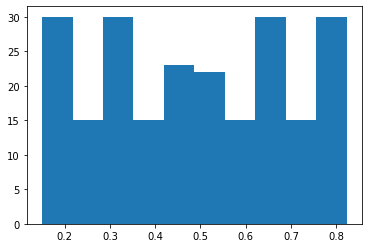

In [31]:
#print(tau1)
plt.hist(tau1)

In [32]:
df1 = pd.DataFrame.from_dict(np.array([np.around(X_heat[:, 0], decimals=3, out=None),
                                          np.around(X_heat[:, 1], decimals=3, out=None),
                                          tau1]).T)

df1.columns = ['X_value','Y_value','Z_value']

df1['Z_value'] = pd.to_numeric(df1['Z_value'])

df1 = df1.pivot('X_value','Y_value','Z_value')

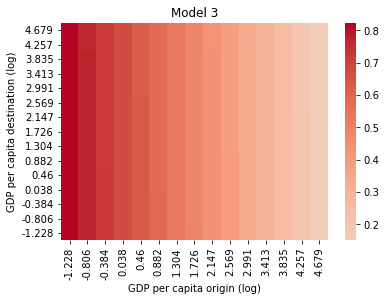

In [33]:

df1.sort_index(level=0, ascending=False, inplace=True)

import seaborn as sns
sns.heatmap(df1,
            cmap='coolwarm',
            center=0)

# Add title and labels to plot.
plt.title('Model 3')
plt.xlabel('GDP per capita origin (log)')
plt.ylabel('GDP per capita destination (log)')
plt.savefig("charts/heatmap_model_3.png", bbox_inches='tight')

#### Prediction of treatment performance

Firstly we compute some stats about the classification

In [34]:
# we have the three models from the k fold cross validation
est1.models_propensity

[[RandomForestClassifier(class_weight='balanced_subsample', criterion='entropy',
                         min_samples_leaf=15, n_estimators=75, n_jobs=-1),
  RandomForestClassifier(class_weight='balanced_subsample', criterion='entropy',
                         min_samples_leaf=15, n_estimators=75, n_jobs=-1),
  RandomForestClassifier(class_weight='balanced_subsample', criterion='entropy',
                         min_samples_leaf=15, n_estimators=75, n_jobs=-1),
  RandomForestClassifier(class_weight='balanced_subsample', criterion='entropy',
                         min_samples_leaf=15, n_estimators=75, n_jobs=-1)]]

In [35]:
# we can print the score of the models
print(est1.nuisance_scores_propensity)

[[0.804905875641757, 0.8003422703936109, 0.7837992013690815, 0.8117512835139761]]


Feature importance from the tree:

In [36]:
est1_t = est1.models_propensity[0][0]

In [37]:
from sklearn.metrics import classification_report

est1_t_predicted = est1_t.predict(XX_test)

print(classification_report(t_test, est1_t_predicted))

              precision    recall  f1-score   support

           0       0.88      0.80      0.84       501
           1       0.69      0.81      0.74       279

    accuracy                           0.80       780
   macro avg       0.79      0.80      0.79       780
weighted avg       0.81      0.80      0.80       780



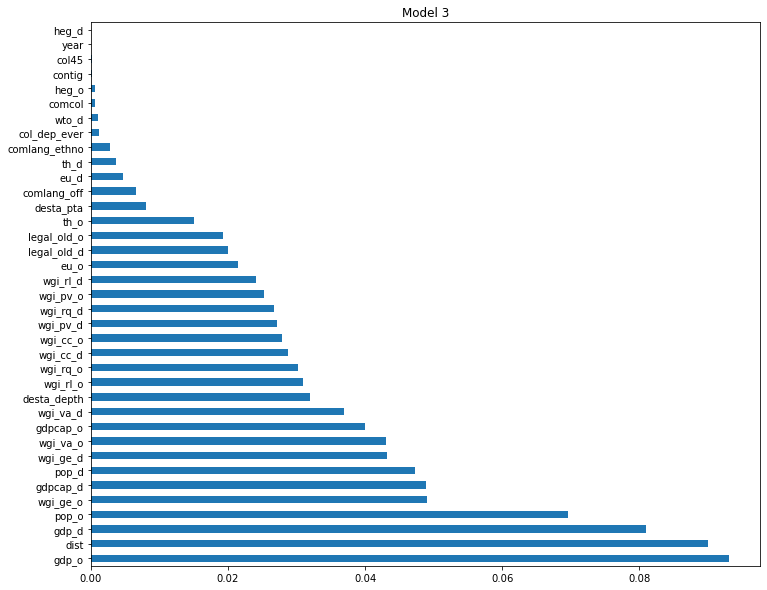

In [38]:
feat_importances = pd.Series(est1_t.feature_importances_, index=W_names)

fig = matplotlib.pyplot.gcf()
plt.title('Model 3')
fig.set_size_inches(12, 10)
feat_importances.nlargest(37).plot(kind='barh')
fig.savefig('charts/pred_treat_importance_model_3.png', dpi=100, bbox_inches='tight')


We can also plot one of the 75 trees that make up the random three:

In [39]:
est1_t_tree = est1_t.estimators_[0]

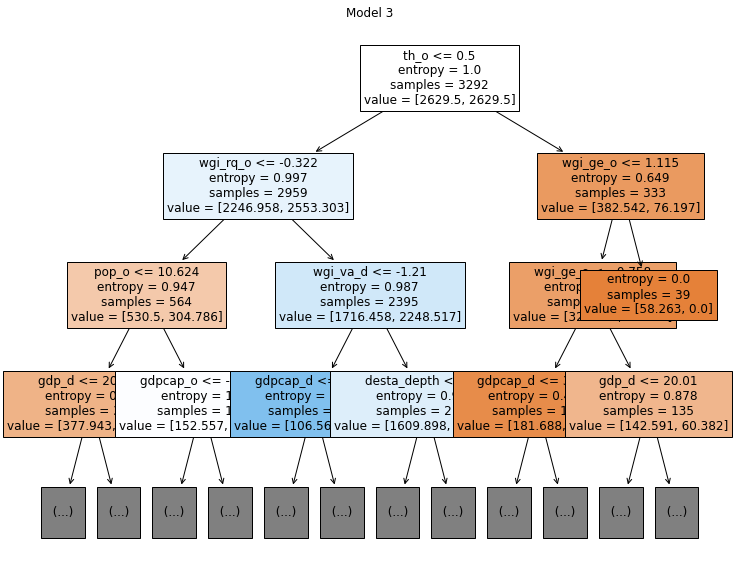

In [40]:
from sklearn import tree
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(12, 10)
tree.plot_tree(est1_t.estimators_[0],
               max_depth = 3,
               feature_names = W_names, 
               fontsize=12,
               #class_names=cn,
               filled = True)

plt.title('Model 3')
plt.savefig("charts/pred_treat_tree_model_3.png", bbox_inches='tight')
               

We can also display how the model predicts treatment:

In [41]:
import shap 

In [42]:
XX_test[0,:].shape

The force plot shows how the model constructs the prediction for a single observation. In red are features that increase the probability of treatment, in blue the ones that decrease it. The base value is 0.5

In [43]:
explainer = shap.TreeExplainer(est1_t, feature_names=W_names)
mean_t_test = np.mean(t_test)
# Calculate Shap values
choosen_instance = XX_test[0,:]
shap_values = explainer.shap_values(choosen_instance)


shap.initjs()
f = shap.force_plot(#explainer.expected_value[1],
                mean_t_test,
                shap_values[1],
                choosen_instance,
                show=True,
                #base_value=mean_t_test,
               feature_names=W_names) #,
               #matplotlib=True)
shap.save_html("charts/pred_treat_shap_model_3.html", f)
#plt.savefig('scratch.png')
f               

In [44]:
np.mean(t_test)

#### Prediction of outcome performance

In [45]:
# we have the three models from the k fold cross validation
est1.models_regression

[[RandomForestRegressor(min_samples_leaf=15, n_estimators=75, n_jobs=-1),
  RandomForestRegressor(min_samples_leaf=15, n_estimators=75, n_jobs=-1),
  RandomForestRegressor(min_samples_leaf=15, n_estimators=75, n_jobs=-1),
  RandomForestRegressor(min_samples_leaf=15, n_estimators=75, n_jobs=-1)]]

In [46]:
print(est1.nuisance_scores_regression)

[[0.6064396129591123, 0.594408192006332, 0.553044494908447, 0.5926275746120893]]


In [47]:
est1_y = est1.models_regression[0][0]

In [48]:
est1_y.feature_importances_.shape

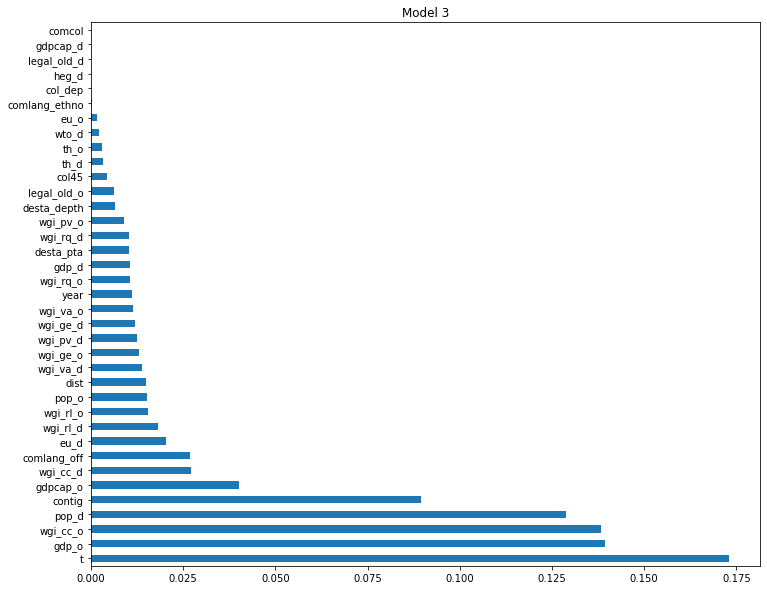

In [49]:
outcome_importances = pd.Series(est1_y.feature_importances_ , index=W_names_out  ) #index=W_names  

fig = matplotlib.pyplot.gcf()
plt.title('Model 3')
fig.set_size_inches(12, 10)
outcome_importances.nlargest(37).plot(kind='barh')
fig.savefig('charts/pred_outcome_importance_model_3.png', dpi=100, bbox_inches='tight')

In [50]:
est1_y_predicted = est1_y.predict(XX_test_out)

In [51]:
est1_y.score(XX_test_out, y_test) # R squared

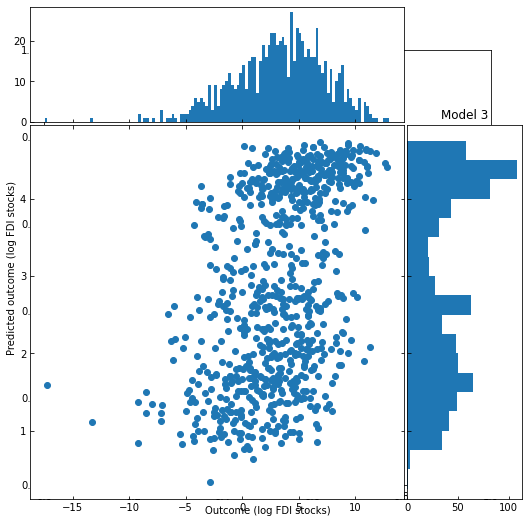

In [52]:

x = y_test
y = est1_y_predicted

# definitions for the axes
left, width = 0.1, 0.65
bottom, height = 0.1, 0.65
spacing = 0.005


rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom + height + spacing, width, 0.2]
rect_histy = [left + width + spacing, bottom, 0.2, height]

# start with a rectangular Figure
plt.figure(figsize=(8, 8))
plt.xlabel('Outcome (log FDI stocks)')
plt.ylabel('Predicted outcome (log FDI stocks)')

ax_scatter = plt.axes(rect_scatter)
ax_scatter.tick_params(direction='in', top=True, right=True)
ax_histx = plt.axes(rect_histx)
ax_histx.tick_params(direction='in', labelbottom=False)
ax_histy = plt.axes(rect_histy)
ax_histy.tick_params(direction='in', labelleft=False)

# the scatter plot:
ax_scatter.scatter(x, y)

# now determine nice limits by hand:
binwidth = 0.25
lim = np.ceil(np.abs([x, y]).max() / binwidth) * binwidth
#ax_scatter.set_xlim((-lim, lim))
#ax_scatter.set_ylim((-lim, lim))

bins = np.arange(-lim, lim + binwidth, binwidth)
ax_histx.hist(x, bins=bins)
ax_histy.hist(y, bins=bins, orientation='horizontal')
plt.title('Model 3')
ax_histx.set_xlim(ax_scatter.get_xlim())
ax_histy.set_ylim(ax_scatter.get_ylim())



#plt.show()
plt.savefig('charts/pred_outcome_scatter_model_3.png', dpi=100, bbox_inches='tight')

In [53]:
pd.set_option('display.max_rows', 500)
est1.effect_inference(X_heat).summary_frame(alpha=0.1, value=0, decimals=3)

,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
X,,,,,,
0,0.823,0.237,3.472,0.001,0.433,1.213
1,0.775,0.225,3.450,0.001,0.406,1.145
2,0.728,0.213,3.409,0.001,0.376,1.079
3,0.680,0.203,3.344,0.001,0.345,1.014
4,0.632,0.195,3.250,0.001,0.312,0.952
5,0.585,0.187,3.121,0.002,0.277,0.893
6,0.537,0.182,2.953,0.003,0.238,0.836
7,0.489,0.178,2.746,0.006,0.196,0.782
8,0.442,0.177,2.502,0.012,0.151,0.732
